In [1]:
import torch
import matplotlib.pyplot as plt
from torch import optim, distributions, nn
from tqdm.notebook import tqdm
import gpzoo
from gpzoo.kernels import NSF_RBF, batched_RBF, batched_MGGP_RBF
from gpzoo.gp import GaussianPrior, SVGP, VNNGP, MGGP_SVGP
from gpzoo.likelihoods import PNMF, NSF2, Hybrid_NSF2
from gpzoo.utilities import train_hybrid, train_hybrid_batched, anndata_to_train_val, plot_factors, rescale_spatial_coords, add_jitter, init_softplus
import squidpy as sq
import numpy as np
from sklearn.decomposition import NMF
import scanpy as sc
import random

from gpzoo.utilities import regularized_nmf, dims_autocorr
from matplotlib.animation import FuncAnimation
from matplotlib import animation
import pickle
from sklearn.cluster import KMeans

/gladstone/engelhardt/home/lchumpitaz/gitclones/GPzoo/gpzoo/utilities.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def plot_factors(factors, X, moran_idx=None, ax=None, size=7, alpha=0.8, s=0.1, names=None):

    max_val = np.percentile(factors, 95)
    min_val = np.percentile(factors, 5)

    
    if moran_idx is not None:
        factors = factors[moran_idx]
        if names is not None:
            names = names[moran_idx]

    L = len(factors)

    if ax is None:
        fig, ax = plt.subplots(2, 5, figsize=(size*5, size*2), tight_layout=True)
        
    for i in range(L):
        
        
        curr_ax = ax[i//5, i%5]
        
        
        
        curr_ax.scatter(X[:, 0], X[:,1], c=factors[i], vmin=min_val, vmax=max_val, alpha=alpha, cmap='turbo', s=s)

        curr_ax.invert_yaxis()
        if names is not None:
            curr_ax.set_title(names[i], x=0.03, y=.88, fontsize="small", c="white",
                     ha="left", va="top")
        curr_ax.set_xticks([])
        curr_ax.set_yticks([])
        curr_ax.set_facecolor('xkcd:gray')

In [3]:
adata = sq.datasets.slideseqv2()
adata = adata.raw.to_adata()

/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/gpzoo/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/gpzoo/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


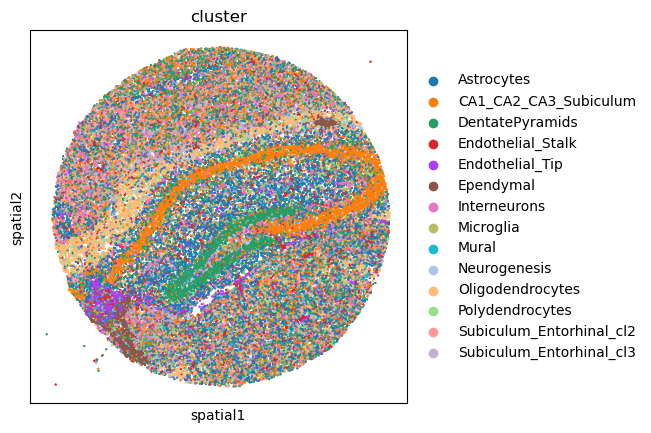

In [4]:
sq.pl.spatial_scatter(adata, color="cluster", size=1, shape=None);


<Axes: >

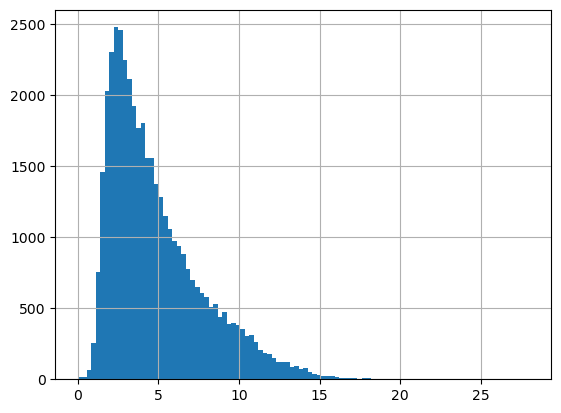

In [5]:
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)
adata.obs.pct_counts_mt.hist(bins=100)


In [6]:
adata = adata[adata.obs.pct_counts_mt < 20] #from 53K to 45K
sc.pp.filter_cells(adata, min_counts=100)
sc.pp.filter_genes(adata, min_cells=10)

/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/gpzoo/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_counts"] = number


In [7]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=1)

In [8]:
Dtr, Dval = anndata_to_train_val(adata, sz="scanpy")

In [9]:
Y = Dtr['Y'].T
Y = Y[~adata.var.MT]
X = Dtr['X']*50
V = Dtr['sz']

In [10]:
Y.shape

(17702, 39694)

In [11]:
factors, loadings = regularized_nmf(Y.T/V, L=20, shrinkage=0.3, max_iter = 1000, solver='mu', init='nndsvdar', beta_loss='kullback-leibler', random_state=997)

In [12]:
moran_idx, moranI = dims_autocorr(np.exp(factors), X)

here_andata


In [13]:
moranI

array([0.84990645, 0.83133936, 0.78411198, 0.68100205, 0.67007985,
       0.63701076, 0.60972301, 0.59681771, 0.43688348, 0.34527911,
       0.29278412, 0.29277887, 0.27153335, 0.25736647, 0.24015926,
       0.19190176, 0.11695786, 0.08667006, 0.07643669, 0.06880896])

In [14]:
factors_ordered=factors[:, moran_idx]
loadings_ordered=loadings[:, moran_idx]

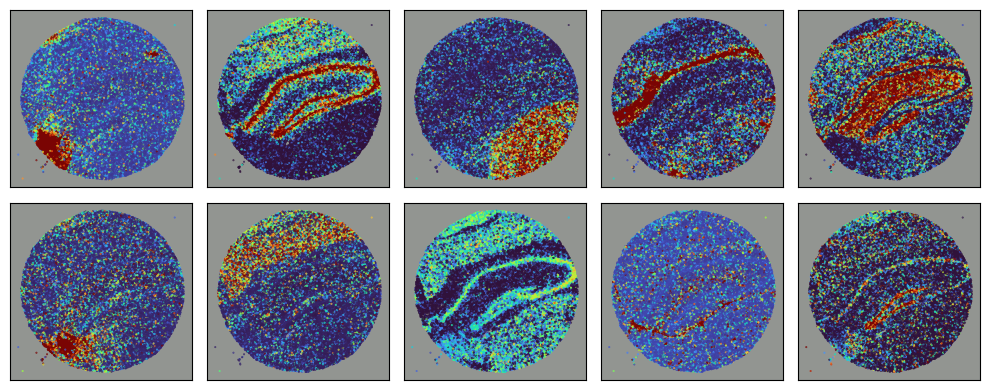

In [15]:
plot_factors(np.exp(factors.T), X, moran_idx=moran_idx[0:10], ax=None, size=2, s=0.2, alpha=0.9)

In [16]:
X = torch.tensor(X).type(torch.float)
Y = torch.tensor(Y).type(torch.float)
groupsX = torch.tensor(adata[Dtr['idx']].obs.cluster.values.codes).type(torch.LongTensor)
n_groups = len(adata.obs.cluster.values.categories)

<BarContainer object of 14 artists>

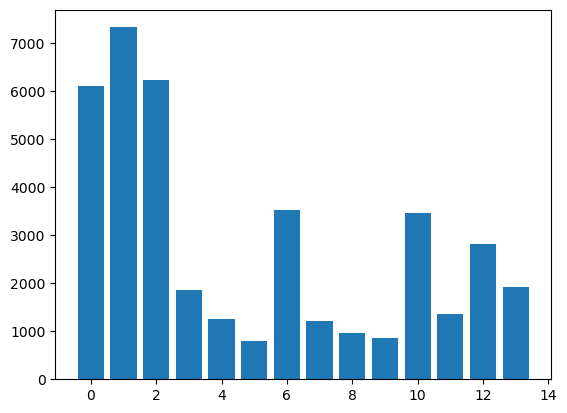

In [17]:
plt.bar(*torch.unique(groupsX, return_counts=True))

In [18]:
def build_model(Y, M=215, L=10):
    

    torch.manual_seed(0)



    groupsX = torch.tensor(adata[Dtr['idx']].obs.cluster.values.codes).type(torch.LongTensor)
    n_groups = len(adata.obs.cluster.values.categories)

    scale = len(groupsX)//M

    Z = []
    groupsZ = []
    for i in range(n_groups):
        mask = groupsX==i
    
        number_clusters = (int(sum(mask))//scale)
        kmeans = KMeans(n_clusters=number_clusters, random_state=240, n_init="auto").fit(X[mask])
        Z.append(kmeans.cluster_centers_)
        groupsZ += number_clusters*[i]
    Z = np.concatenate(Z)

    
    Z = nn.Parameter(torch.tensor(Z).type(torch.float), requires_grad=False)
    groupsZ = nn.Parameter(torch.tensor(groupsZ).type(torch.LongTensor), requires_grad=False)

    M = len(Z) #new M which should be close to original M

    
    
    kernel = batched_MGGP_RBF(sigma=[1.0]*L, lengthscale=[2.0]*L, group_diff_param=[1.0]*L, n_groups=n_groups)

    gp = MGGP_SVGP(kernel, M=M, n_groups=n_groups, jitter=1e-2)

    
    Kzx = kernel.forward(Z, X, groupsZ, groupsX).contiguous()
    Kxz = torch.transpose(Kzx, -2, -1)
    Kzz = kernel.forward(Z, Z, groupsZ, groupsZ).contiguous()

    

    all_factors = torch.tensor(factors_ordered.T)[:L, :, None].type(torch.float)
    L1 = torch.linalg.cholesky(add_jitter(Kzx@Kxz, 1e-5))
    

    solved1 = torch.cholesky_solve(Kzx@all_factors, L1)
    print('solved1 shape:', solved1.shape)
    
    
    mu = Kzz@solved1

    print('here')
    
    
    # gp.mu = nn.Parameter(torch.randn((L, M)).type(torch.float))
    
    gp.mu = nn.Parameter(torch.squeeze(mu).clone().detach()).type(torch.float)
    
    Lu = 1e-2*torch.eye(M).expand(L, M, M)
    gp.Lu = nn.Parameter(Lu.clone().detach())
    
    gp.Z = Z
    gp.groupsZ = groupsZ

    prior = GaussianPrior(Y, L=L)
    prior.mean = nn.Parameter(torch.squeeze(torch.tensor(factors_ordered[:, L:].T)).clone().detach()).type(torch.float)

    

    model = Hybrid_NSF2(gp, prior, Y, L=L, T=L)


    model.sf.W = nn.Parameter(torch.tensor(init_softplus(loadings_ordered)[:, :L]).type(torch.float)) 
    model.cf.W = nn.Parameter(torch.tensor(init_softplus(loadings_ordered)[:, L:]).type(torch.float)) 


    model.V = nn.Parameter(torch.squeeze(torch.tensor(init_softplus(V)).type(torch.float))) 
    
    model.to(device)
    return model

In [19]:
# def build_model_scratch(Y, M=215, L=10):
    

#     torch.manual_seed(0)


#     groupsX = torch.tensor(adata[Dtr['idx']].obs.cluster.values.codes).type(torch.LongTensor)
#     n_groups = len(adata.obs.cluster.values.categories)

#     idx = torch.multinomial(torch.ones(X.shape[0]), num_samples=M*n_groups, replacement=False)

    
#     Z = nn.Parameter(X[idx]).type(torch.float)
#     groupsZ = nn.Parameter(groupsX[idx].type(torch.LongTensor), requires_grad=False)

    
    
#     kernel = batched_MGGP_RBF(sigma=[1.0]*L, lengthscale=[2.0]*L, group_diff_param=[1.0]*L, n_groups=n_groups)

#     gp = MGGP_SVGP(kernel, M=M, n_groups=n_groups, jitter=1e-2)

    
 
#     gp.mu = nn.Parameter(torch.randn((L, M*n_groups)).type(torch.float))    
#     Lu = 1e-2*torch.eye(M*n_groups).expand(L, M*n_groups, M*n_groups)
#     gp.Lu = nn.Parameter(Lu.clone().detach())
    
#     gp.Z = nn.Parameter(Z, requires_grad=False)
#     gp.groupsZ = groupsZ

#     prior = GaussianPrior(Y, L=L)
#     model = Hybrid_NSF2(gp, prior, Y, L=L, T=L)
    
#     model.to(device)
#     return model

In [20]:
model = build_model(Y, M=3000)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f0e79a7d5e0>
Traceback (most recent call last):
  File "/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/gpzoo/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/gpzoo/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/gpzoo/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/gpzoo/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has n

solved1 shape: torch.Size([10, 3045, 1])
here


In [21]:
# model = build_model(Y, M=215)

In [22]:
# model.load_state_dict(torch.load('slideseq_mggp_nsf_3010.pth'))

calculating Kxx
calculating Kzx
calculating kzz
torch.Size([10, 3045, 3045])
calculating cholesky
calculating W


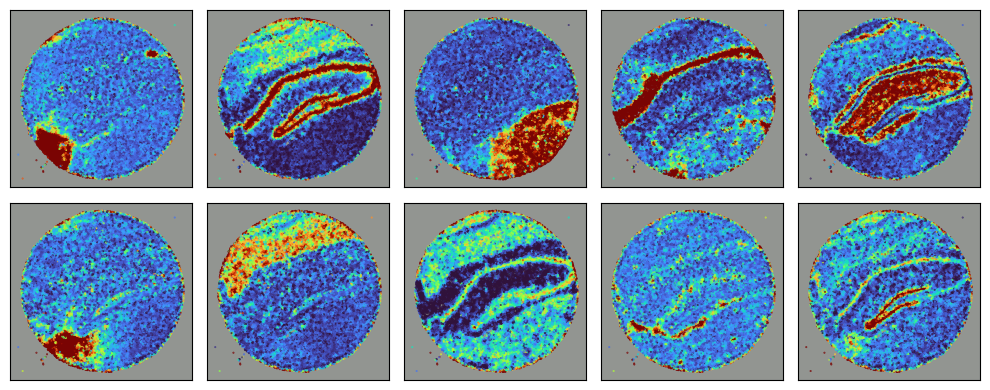

In [23]:
model.cpu()

groupsX = torch.tensor(adata[Dtr['idx']].obs.cluster.values.codes).type(torch.LongTensor)

qF, _, _ = model.sf.prior(X, groupsX, verbose=True)

mean = torch.exp(qF.mean).detach().numpy()
plot_factors(mean, X, moran_idx=None, ax=None, size=2, s=0.2, alpha=0.9)

In [25]:
X_train = X.to(device)
Y_train = Y.to(device)
groupsX_train = groupsX.to(device)

In [28]:
def model_grads(model):
    model.sf.prior.kernel.sigma.requires_grad = False
    model.sf.prior.kernel.lengthscale.requires_grad = False
    model.sf.prior.kernel.group_diff_param.requires_grad = False
    model.sf.prior.Z.requires_grad=False
    model.sf.prior.mu.requires_grad=False
    model.sf.prior.Lu.requires_grad=True
    model.sf.W.requires_grad=False

    model.cf.prior.mean.requires_grad=False
    model.cf.prior.scale.requires_grad=True
    model.cf.W.requires_grad=False

    model.cf.prior.scale_pf = 1.0
    
    
    model.V.requires_grad=False

In [29]:
model_grads(model)

In [30]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

In [31]:
def train_batched(model, optimizer, X, groupsX, y, device, steps=200, E=20, batch_size=1000, **kwargs):
    losses = []
    
    means = []
    scales = []
    idxs = []
    
    for it in tqdm(range(steps)):
        
        idx = torch.multinomial(torch.ones(X.shape[0]), num_samples=batch_size, replacement=False)
        
        
        optimizer.zero_grad()
        pY, qF, qU, pU, qF2, pF2 = model.forward_batched(X=X, idx=idx, groupsX=groupsX[idx], E=E, **kwargs)

        logpY = y[:, idx]*torch.log(pY.rate) - pY.rate

        ELBO = (logpY).mean(axis=0).sum()
        ELBO -= torch.sum(distributions.kl_divergence(qU, pU))
        ELBO -= torch.sum(distributions.kl_divergence(qF2, pF2))
        
        loss = -ELBO
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        if (it%10)==0:
            idxs.append(idx.detach().cpu().numpy())
            means.append(torch.exp(qF.mean.detach().cpu()).numpy())
            scales.append(qF.scale.detach().cpu().numpy())
    
    with torch.no_grad():
        if device.type=='cuda':
            torch.cuda.empty_cache()
        
    return losses, means, scales, idxs

In [32]:
steps = 5000
model.to(device)

Hybrid_NSF2(
  (sf): PoissonFactorization(
    (prior): MGGP_SVGP(
      (kernel): batched_MGGP_RBF()
    )
  )
  (cf): PoissonFactorization(
    (prior): GaussianPrior()
  )
)

In [33]:
model.sf.prior.jitter=1e-2

In [34]:
losses, means, scales, idxs = train_batched(model, optimizer, X_train, groupsX_train, Y_train, device, steps=steps, E=3, batch_size=6000)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [41]:
# torch.save(model.state_dict(), 'slideseq_mggp_nsf_3000.pth')

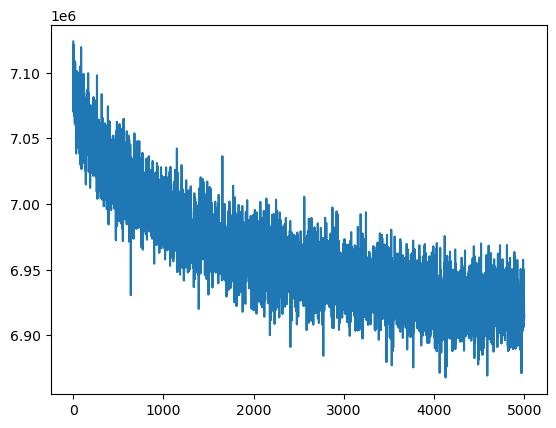

In [38]:
plt.plot(losses)

In [39]:
model.sf.prior.kernel.lengthscale

Parameter containing:
tensor([2., 2., 2., 2., 2., 2., 2., 2., 2., 2.], device='cuda:1')

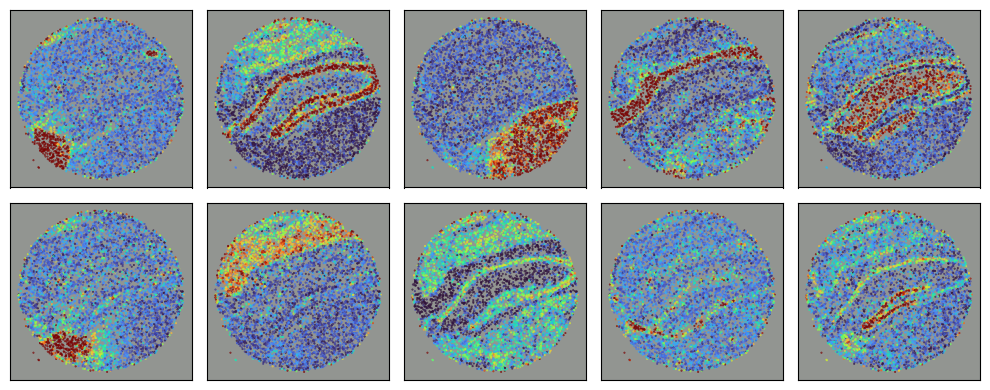

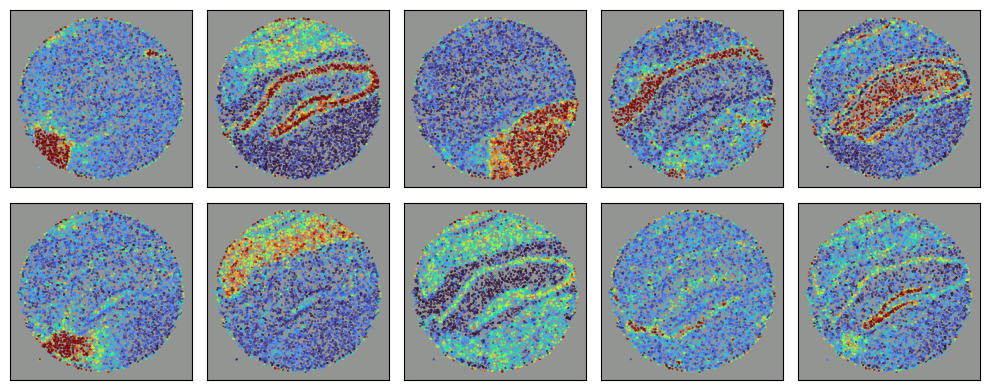

In [40]:
plot_factors(means[0], X[idxs[0]], moran_idx=None, ax=None, size=2, s=0.2, alpha=0.9)
plot_factors(means[-1], X[idxs[-1]], moran_idx=None, ax=None, size=2, s=0.2, alpha=0.9)


In [ ]:
model.cpu()

qF2, _ = model.cf.prior()
means2 = torch.exp(qF2.mean).detach().numpy()

In [ ]:
plot_factors(means2, X, moran_idx=None, ax=None, size=2, s=0.2, alpha=0.9)


In [ ]:
# size=2
# fig, ax = plt.subplots(2, 5, figsize=(size*5, size*2), tight_layout=True)


# def update(iteration):
#     for element in ax:
#         for element in element:
#             element.cla()
        
#     curr_factor = means[iteration]

    
    
#     plot_factors(curr_factor, X, ax=ax, size=2, s=0.6, alpha=1)

# #     fig.suptitle(f"Iteration: {iteration}, Loss: {losses[iteration*10]:0.2f}")
# #     fig.tight_layout()
#     print('hi', iteration)


# anim = FuncAnimation(fig, update, frames=np.arange(0, 600, 1), interval=100)
# plt.close()z
# # anim.save('pnmf.mp4',
# #          writer=animation.FFMpegWriter(fps=50, bitrate=2000, codec='h264'),
# #          dpi=50)
# anim.save("visium_vnngp.mp4", fps=60, dpi=100)